In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

*1. Загрузка данных*

In [47]:
# Загрузка датасета
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [48]:
# Изучим исходные данные
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [49]:
print(train_dataset.data.shape)
print(train_dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [50]:
print(test_dataset.data.shape)
print(test_dataset.targets.shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


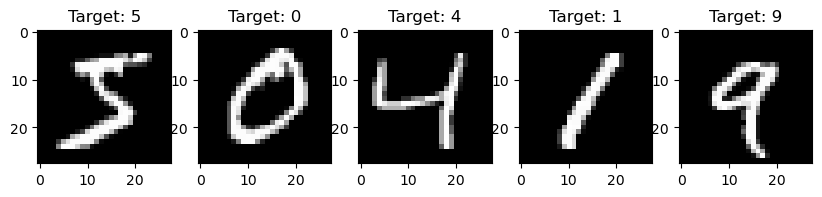

In [51]:
# Посмотрим на сами данные
fig, axes = plt.subplots(1, 5, figsize = (10, 3))

# id изображения, само изображения, целевая переменная
for ax, image, label in zip(axes, train_dataset.data, train_dataset.targets):

    ax.imshow(image, cmap = 'gray')
    # укажем, какой цифре соответствует изображение
    ax.set_title(f'Target: {label}')

2. *Нормализация данных*

In [52]:
# Разделим исходные данные
X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

In [53]:
# Приведём распредение данных к интервалу [-1, 1]
X_train = 2. * (X_train - np.min(X_train)) / np.ptp(X_train) - 1
X_test = 2. * (X_test - np.min(X_test)) / np.ptp(X_test) - 1

In [54]:
# Вытянем изображения в один вектор
X_train = X_train.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))

# посмотрим на результат
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [94]:
# Посмотим на итог нормализации
# Возмём первое изображение [0] и пиксели с 200 по 209
X_train[0][200:210]

array([-1.        , -1.        , -1.        , -0.61568627,  0.86666667,
        0.98431373,  0.98431373,  0.98431373,  0.98431373,  0.98431373])

In [95]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

*3. Конфигурация Многослойного Перцептрона* 

* Создадим многослойный Перцептрон:
* Входной слой: 64 наблюдения * 784 признака
* 2 скрытых слоя по 64 нейрона - функция активации: ReLu
* Выходной слой: 10 неиронов, по одной а каждую цифру - функция активации: SoftMax (включено в CrossEntropyLoss)

In [ ]:
# Определение модели
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Инициализация весов Glorot Uniform
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Выберем размер выборки
batch_size = 64

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [159]:
# Инициализация и настройка модели
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

*4. Обучение*

In [ ]:
# for size_idx, batch in enumerate(batch_sizes):
#     # Обновим загрузчик данных
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [160]:
train_correct = []
test_correct = []

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for b, (batch, labels) in enumerate(train_loader):
        
        # Прямой проход
        predictions = model(batch)
        loss = criterion(predictions, labels)
        
        # Обратный проход
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Считаем результат
        running_loss += loss.item()
        predicted = torch.max(predictions.data, 1)[1]
        total += labels.size(0)
        batch_correct = (predicted == labels).sum().item()
        correct += batch_correct
        
        if b % 100 == 0 and b != 0:
            print(f'Epoch: {epoch} Batch: {b} [{batch_size * b:6}/60000] Train loss: {loss.item():10.8f} Train accuracy: {batch_correct / batch_size:7.4f}')
    
    # Запоминаем точность для эпохи
    train_correct.append(correct)
    print(f'\nEpoch {epoch} Result, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}, time: {time.time() - start_time:.2} sec\n')

    # Оценка модели на тестовых данных
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted = torch.max(predictions.data, 1)[1]
        correct = (predicted == y_test_tensor).sum().item()
        accuracy = correct / y_test_tensor.size(0)
        
        # Запоминаем точность для тестовой выборки для эпохи
        test_correct.append(correct)
        print(f'Epoch {epoch} Test Accuracy: {accuracy:.4f}\n')
    

Epoch: 1 Batch: 100 [  6400/60000] Train loss: 0.48973677 Train accuracy:  0.8438
Epoch: 1 Batch: 200 [ 12800/60000] Train loss: 0.30091932 Train accuracy:  0.9062
Epoch: 1 Batch: 300 [ 19200/60000] Train loss: 0.36007732 Train accuracy:  0.9219
Epoch: 1 Batch: 400 [ 25600/60000] Train loss: 0.26046872 Train accuracy:  0.9375
Epoch: 1 Batch: 500 [ 32000/60000] Train loss: 0.60698223 Train accuracy:  0.8125
Epoch: 1 Batch: 600 [ 38400/60000] Train loss: 0.28539333 Train accuracy:  0.9062
Epoch: 1 Batch: 700 [ 44800/60000] Train loss: 0.22594382 Train accuracy:  0.9375
Epoch: 1 Batch: 800 [ 51200/60000] Train loss: 0.06283192 Train accuracy:  0.9844
Epoch: 1 Batch: 900 [ 57600/60000] Train loss: 0.23090437 Train accuracy:  0.9531

Epoch 1 Result, Loss: 0.4501, Accuracy: 0.8563, time: 3.6 sec

Epoch 1 Test Accuracy: 0.9163

Epoch: 2 Batch: 100 [  6400/60000] Train loss: 0.17017435 Train accuracy:  0.9531
Epoch: 2 Batch: 200 [ 12800/60000] Train loss: 0.18560944 Train accuracy:  0.9531
Epo

*5. Прогноз*

In [146]:
# Прогноз для последних 10 изображений
with torch.no_grad():
    last_10 = X_test_tensor[-10:]
    predictions = model(last_10)
    _, predicted = torch.max(predictions, 1)
    print("Pred labels: ", predicted.numpy())
    print("True labels: ", y_test_tensor.numpy()[-10:])

Pred labels:  [7 8 9 0 1 2 3 4 5 6]
True labels:  [7 8 9 0 1 2 3 4 5 6]
